# CE 424 Scheduling Lab

In [2]:
from collections import deque
import matplotlib.pyplot as plt
import numpy as np
from random import expovariate
%matplotlib inline

import doctest
def test(fun, verbose=False):
    doctest.run_docstring_examples(fun, None, name=fun.__name__, verbose=verbose)

## Task Model

Our model of a task ignores what computation and I/O it actually does; we are only interested in its scheduling events.  This is captured by three basic parameters, all of which operate in an abstract time unit, say ms:

* arrival - the time at which the task is first initiated
* total - total execution time of the task (how long it runs).  Generally we don't know this value, although to simulate oracle scheduling we could peek.  It determines when the task exits.
* burst_fun - a function that returns the length of the next CPU burst, given its elapsed execution time.  This can be viewed as the time to the next syscall.  A value of 0 is taken to be run-to-completion.  A periodic application simply returns a constant, the number of time units in each burst duration.  A stochastic model is obtained by drawing a value according to some distribution.
* io_burst_fun - a function that returns the length of time the task spends waiting for I/O etc.



The overall workload is described by a stream of such tasks.

In [3]:
class Task(object):
    """ Model of a program task: 
    arrives as a certain time and then alternates CPU and IO bursts of possibly varying length
    till it has executed for a certain amount of CPU time
    """
    task_number = 0   # Unique identifier for each task
    
    def __init__(self, arrival, total, burst_fun, io_burst_fun):
        """Create a task with specified arrival, total run time, and functions modeling burst lengths."""
        Task.task_number += 1
        self.task = Task.task_number
        self.arrival_time = arrival
        self.total_run_time = total
        self.cpu_burst = burst_fun
        self.io_burst = io_burst_fun
        return None
    
    def __repr__(self):
        return "Task {} arr:{} len:{}".format(self.task, self.arrival_time, self.total_run_time)

class TaskStream(object):
    """Stream of tasks arriving as time moves forward"""
    def __init__(self, tasks):
        self.tasks = sorted(tasks, key=lambda x: x.arrival_time)
    
    def next_arrival(self):
        if not self.tasks:
            return None
        return self.tasks[0].arrival_time
    
    def enter_tasks(self, time):
        """Generate a thread for and remove each tasks arriving upto time. """
        for task in self.tasks.copy():
            if task.arrival_time <= time:
                self.tasks.remove(task)
                yield Thread(task)

    def show(self):
        for t in self.tasks:
            print(t)

## Thread Model

The execution of the steps of a task is emulated by `Thread` class `run` method.  It is passed the length of the CPU quanta up to which may run, with `q == 0` indicating indefinitely, i.e., to the end of its burst or to completion.  Based on its internal bookkeeping, i.e., where the thread is in the current burst and the task time to completion, 
`run` determines how long the thread will run and returns that value along with a status indicating whether the
thread continues to run at the end of the quantum ("cpu"), blocked before the quantum ("io"), or ran to completion ("done"). 

One subtlety is that if a tasks is scheduled multiple times to complete a burst, the `burst_fun` is not used until the task is rescheduled after the completes, i.e., it would be returning from the syscall.

In [4]:
class Thread(object):
    """ Model of a running process thread.
    
    Each time a task is run, it executes for 1 or more time units, until it
    - completes a cpu burst
    - exhausts a quanta (under preemptive scheduling), or
    - completes
    """
    
    def __init__(self, task):
        """Create a thread object with characteristics of modeled task."""
        self.task = task
        self.elapsed_time = 0
        self.last_queued = None
        self.wait_time = 0
        self.remaining_burst = None
        self.wakeup_time = None
    
    def __repr__(self):
        return "Thread {} | elapsed: {} wait:{} rbrst:{} wakeup: {}".format(self.task, 
                                    self.elapsed_time, self.wait_time, self.remaining_burst, self.wakeup_time)
        
    def remaining(self):
        return self.task.total_run_time - self.elapsed_time
    
    def run(self, q=0):
        """ Advance the thread for up to q units (q==0 is nonpremptive) till cpu burst completes or done"""
        io_time = None
        if (self.remaining_burst):  # Still completing burst
            if q > 0:                 # preemptive : run for Q, burst done, or pgm done
                run_len = min(q, self.remaining_burst, self.remaining())
            else:                      # non-preemptive : run till burst or pgm down
                run_len = min(self.remaining_burst, self.remaining())
            self.remaining_burst -= run_len
            self.elapsed_time += run_len
            if self.remaining_burst:                    # Still working on prior CPU burst
                status = 'cpu'
            else:
                status = 'io'                            # completed the burst, start wait
                io_time = self.task.io_burst(self.elapsed_time) 
        else:                                                             # starting a new burst
            burst = self.task.cpu_burst(self.elapsed_time)   
            if burst == 0 and q == 0:                                # run till done
                run_len = self.remaining()           
            elif burst == 0:                                           # run till Q or done
                run_len = min(q, self.remaining())  
            elif q == 0:                                               # run till burst or done
                run_len = min(burst, self.remaining())
            else:                                                         # run till Q, burst, or done
                run_len = min(q, burst, self.remaining())

            self.elapsed_time += run_len
            if burst == 0:
                status = 'cpu'
            elif run_len < burst:                           # Continue CPU burst
                self.remaining_burst = burst - run_len
                status = 'cpu'
            else:                                          # Completed CPU burst, start I/O wait
                status = 'io'
                io_time = self.task.io_burst(self.elapsed_time) 

        if self.remaining() <= 0:             # override status if thread finished
            status = 'done'
        return run_len, status, io_time

## Processor  Model

We also have a very simple model of a process.  It moves forward in time, either sitting idle or executing a task.  

The one complexity is that if tasks arrive or IO completes while a thread is being run, they need to be entered into the ready queue.  Thus, our processor model needs access to the task stream and the enqueue method of the scheduler for such starts and restarts.

In [5]:
class Machine(object):
    """
    Simulate machine.  
    Time moves forward, either idling or running - this is the only property of the machine
    Along the way, it consumes the list of future tasks, builds a log of its actions,
    and records the summary of every thread.
    """
    def __init__(self, task_stream, ready, verbose=False):
        self.time = 0   
        
        self.log = [(0, 'start')]
        self.threads = []
        self.verbose = verbose
        
        self.io = []
        self.future = task_stream
        self.ready = ready
        self._arrivals()
        
    def pending(self):
        return self.future.tasks or self.io
    
    def next_start(self):
        """Return time of next start or -1 if none."""
        next_taskstart = self.future.next_arrival()
        if self.io and next_taskstart:
            return min(next_taskstart, min([t.wakeup_time for t in self.io]))
        elif self.io:
            return min([t.wakeup_time for t in self.io])
        else:
            return next_taskstart
        
    def io_wait(self, thread, wait_time):
        """ Put thread completed cpu burst with positive wait time in IO queue till wakeup"""
        thread.wakeup_time = self.time + wait_time
        self.io.append(thread)
        if self.verbose:
            print("{0}: IO wait for Task {1} for duration {2}".format(self.time, thread.task.task, wait_time))
        self.log.append((self.time, 'io wait', thread.task, wait_time))

    def _arrivals(self):
        # Collect new tasks that arrived while this was idling or running
        for thread in self.future.enter_tasks(self.time):
            self.threads.append(thread)
            self.ready.arrive(thread, thread.task.arrival_time)
            if self.verbose:
                print("{0}: Arrival of Task {1} (ready queue length = {2})".format(thread.task.arrival_time, thread.task.task, len(self.ready)))
            self.log.append((thread.task.arrival_time, 'arrive', thread.task, len(self.ready)))
            
        # Collect threads that completed IO
        for thread in self.io.copy():
            if thread.wakeup_time <= self.time:
                self.io.remove(thread)
                self.ready.wake(thread, thread.wakeup_time)
                if self.verbose:
                    print("{0}: Wakeup of Task {1} (ready queue length = {2})".format(thread.wakeup_time, thread.task.task, len(self.ready)))
                self.log.append((thread.wakeup_time, 'wakeup', thread.task, len(self.ready)))
            
    
    def idle(self):
        """
        Idle from current time till next task arrival or IO wait completes.  
        Enter all tasks that arrive or IO complete during idle period ready queue.
        """
        if self.pending():
            idle_time = self.next_start()
            if idle_time > 0:
                if self.verbose:
                    print("{0}: Idle for {1}".format(self.time, idle_time - self.time))
                self.log.append((self.time, 'idle', idle_time - self.time))
                self.time = idle_time          # Processor moves forward in time
                self._arrivals()    
    
    def run(self, run_time, thread):
        """ Advance machine time for run_time.  
        Enter new tasks and IO completes during run into ready queue
        """
        if self.verbose:
            print("{0}: Run Task {1} for duration {2} (ready queue length = {3})".format(self.time, thread.task.task, run_time, len(self.ready)))
        self.log.append((self.time, 'run', thread.task, run_time, len(self.ready), self.ready.weight()))
        self.time += run_time           # All we do to run is move time forward
        self._arrivals()
            
    def stop(self):
        if self.verbose:
            print("{0}: Stop".format(self.time))
        self.log.append((self.time, 'stop'))

# Example Schedulers

Each scheduler consists of a loop over the workload and a data structure that implements its policy.  The
schedule presents the thread with its quanta to the thread model to determine how long it retains the CPU
and the status at the end of that time, i.e. CPU, I/O, Done.  

Based on that determination, it allows the machine to advance to that point in time.  Along the way, tasks
may arrive or threads may complete their I/O wait, so the machine will invoke methods in the scheduler
appropriately.

## FCFS and Round Robin

Both are built on a simple FIFO queue, the latter with preemption using fixed quanta.  The enqueue and dequeue operation take a simulated time as which it occurs so that they can update observational data carried in the task structure for analysis and reporting.

In [6]:
class FIFOQueue:
    """ FIFO Queue of tasks to be scheduled """
    def __init__(self):
        self.queue = deque()
    
    def enqueue(self, thread, at_time):
        thread.last_queued = at_time
        self.queue.appendleft(thread)
        
    def dequeue(self, at_time):
        thread = self.queue.pop()
        thread.wait_time += at_time - thread.last_queued
        return thread
    
    def arrive(self, thread, at_time):
        self.enqueue(thread, at_time)
    
    def wake(self, thread, at_time):
        self.enqueue(thread, at_time)
    
    def empty(self):
        return len(self.queue) == 0
    
    def __len__(self):
        return len(self.queue)
    
    def weight(self):
        return sum([x.task.total_run_time - x.elapsed_time for x in self.queue])
    
    def show(self):
        for e in self.queue:
            print(" ", e)
            
def scheduler(tasks, q, queue_class, verbose=False):
    remaining = TaskStream(tasks)
    ready = queue_class()
    cpu = Machine(remaining, ready, verbose)

    while not ready.empty() or cpu.next_start():
        if ready.empty():
            cpu.idle()
        else:     
            thread = ready.dequeue(cpu.time)
            run_time, status, io_time = thread.run(q)
            cpu.run(run_time, thread)
            if status == 'io' and io_time > 0:
                cpu.io_wait(thread, io_time)
            elif status != 'done':
                ready.enqueue(thread, cpu.time)    
    cpu.stop()
    return cpu
    
def round_robin(tasks, q, verbose=False):
    return scheduler(tasks, q, FIFOQueue, verbose)
    
def fcfs(tasks, verbose=False):
    return round_robin(tasks, 0, verbose)

## Helper Functions for Burst Modeling

In [7]:
# Burst functions and factories

def indefinite(run_time):
    """Run till done"""
    return 0;

def nowait(run_time):
    """No I/O wait."""
    return 0;

def make_periodic(duration):
    """Bursts of constant duration for run or io, i.e., periodic."""
    return lambda rt: duration

def make_exponential(mean_duration):
    """Bursts of duration drawn from an exponential distribution of specified mean."""
    return lambda rt: round(expovariate(1.0/mean_duration))

In [8]:
def analyze(thrds):
    """For now just print it out"""
    print("---")
    for t in thrds:
        print(t)

## Study Cases

In [9]:
Task.task_number = 0

workload1 = [
    Task(0, 4, indefinite, nowait),
    Task(1, 7, indefinite, nowait),
    Task(2, 2, make_periodic(1), make_periodic(4)),     # run 1, IO 4, run 1
    Task(3, 3, make_periodic(1), make_periodic(1))      # run 1, IO 1, run 1, IO 1, run 1
]

# Idle two short, 1 long, four short
workload2 = [
    Task(10,  30, indefinite, nowait),
    Task(20,  30, indefinite, nowait),
    Task(30, 100, indefinite, nowait),
    Task(40,  30, indefinite, nowait),
    Task(60,  30, indefinite, nowait),
    Task(80,  30, indefinite, nowait),
    Task(100,  30, indefinite, nowait)
]

workload3 = [
    Task(0, 4, make_periodic(2), make_periodic(1)),     # run 2, IO 1, run 2
    Task(1, 7, indefinite, nowait),
    Task(2, 2, make_periodic(1), make_periodic(2)),     # run 1, IO 2, run 1
    Task(3, 3, make_periodic(6), make_periodic(1))
]

## Example Testing Code

In [10]:
def test_fcfs_workload1():
    """ Test FCFS on workload1
    
    >>> _ = fcfs(workload1, True)
    0: Arrival of Task 1 (ready queue length = 1)
    0: Run Task 1 for duration 4 (ready queue length = 0)
    1: Arrival of Task 2 (ready queue length = 1)
    2: Arrival of Task 3 (ready queue length = 2)
    3: Arrival of Task 4 (ready queue length = 3)
    4: Run Task 2 for duration 7 (ready queue length = 2)
    11: Run Task 3 for duration 1 (ready queue length = 1)
    12: IO wait for Task 3 for duration 4
    12: Run Task 4 for duration 1 (ready queue length = 0)
    13: IO wait for Task 4 for duration 1
    13: Idle for 1
    14: Wakeup of Task 4 (ready queue length = 1)
    14: Run Task 4 for duration 1 (ready queue length = 0)
    15: IO wait for Task 4 for duration 1
    15: Idle for 1
    16: Wakeup of Task 3 (ready queue length = 1)
    16: Wakeup of Task 4 (ready queue length = 2)
    16: Run Task 3 for duration 1 (ready queue length = 1)
    17: Run Task 4 for duration 1 (ready queue length = 0)
    18: Stop
    """
    return

In [11]:
test(test_fcfs_workload1, True)

Finding tests in test_fcfs_workload1
Trying:
    _ = fcfs(workload1, True)
Expecting:
    0: Arrival of Task 1 (ready queue length = 1)
    0: Run Task 1 for duration 4 (ready queue length = 0)
    1: Arrival of Task 2 (ready queue length = 1)
    2: Arrival of Task 3 (ready queue length = 2)
    3: Arrival of Task 4 (ready queue length = 3)
    4: Run Task 2 for duration 7 (ready queue length = 2)
    11: Run Task 3 for duration 1 (ready queue length = 1)
    12: IO wait for Task 3 for duration 4
    12: Run Task 4 for duration 1 (ready queue length = 0)
    13: IO wait for Task 4 for duration 1
    13: Idle for 1
    14: Wakeup of Task 4 (ready queue length = 1)
    14: Run Task 4 for duration 1 (ready queue length = 0)
    15: IO wait for Task 4 for duration 1
    15: Idle for 1
    16: Wakeup of Task 3 (ready queue length = 1)
    16: Wakeup of Task 4 (ready queue length = 2)
    16: Run Task 3 for duration 1 (ready queue length = 1)
    17: Run Task 4 for duration 1 (ready queue l

In [12]:
def test_round_robin():
    """ Test round robin on workload1
    
    >>> _ = round_robin(workload1, 2, True)
    0: Arrival of Task 1 (ready queue length = 1)
    0: Run Task 1 for duration 2 (ready queue length = 0)
    1: Arrival of Task 2 (ready queue length = 1)
    2: Arrival of Task 3 (ready queue length = 2)
    2: Run Task 2 for duration 2 (ready queue length = 2)
    3: Arrival of Task 4 (ready queue length = 3)
    4: Run Task 3 for duration 1 (ready queue length = 3)
    5: IO wait for Task 3 for duration 4
    5: Run Task 1 for duration 2 (ready queue length = 2)
    7: Run Task 4 for duration 1 (ready queue length = 1)
    8: IO wait for Task 4 for duration 1
    8: Run Task 2 for duration 2 (ready queue length = 0)
    9: Wakeup of Task 3 (ready queue length = 1)
    9: Wakeup of Task 4 (ready queue length = 2)
    10: Run Task 3 for duration 1 (ready queue length = 2)
    11: Run Task 4 for duration 1 (ready queue length = 1)
    12: IO wait for Task 4 for duration 1
    12: Run Task 2 for duration 2 (ready queue length = 0)
    13: Wakeup of Task 4 (ready queue length = 1)
    14: Run Task 4 for duration 1 (ready queue length = 1)
    15: Run Task 2 for duration 1 (ready queue length = 0)
    16: Stop
    """
    return

In [13]:
test(test_round_robin, True)

Finding tests in test_round_robin
Trying:
    _ = round_robin(workload1, 2, True)
Expecting:
    0: Arrival of Task 1 (ready queue length = 1)
    0: Run Task 1 for duration 2 (ready queue length = 0)
    1: Arrival of Task 2 (ready queue length = 1)
    2: Arrival of Task 3 (ready queue length = 2)
    2: Run Task 2 for duration 2 (ready queue length = 2)
    3: Arrival of Task 4 (ready queue length = 3)
    4: Run Task 3 for duration 1 (ready queue length = 3)
    5: IO wait for Task 3 for duration 4
    5: Run Task 1 for duration 2 (ready queue length = 2)
    7: Run Task 4 for duration 1 (ready queue length = 1)
    8: IO wait for Task 4 for duration 1
    8: Run Task 2 for duration 2 (ready queue length = 0)
    9: Wakeup of Task 3 (ready queue length = 1)
    9: Wakeup of Task 4 (ready queue length = 2)
    10: Run Task 3 for duration 1 (ready queue length = 2)
    11: Run Task 4 for duration 1 (ready queue length = 1)
    12: IO wait for Task 4 for duration 1
    12: Run Task 2 

## Exploring Behavior on CPU-only Workloads

In [14]:
# FCFS exhibits convoy effect

fcfs_cpu = fcfs(workload2, True)
analyze(fcfs_cpu.threads)

0: Idle for 10
10: Arrival of Task 5 (ready queue length = 1)
10: Run Task 5 for duration 30 (ready queue length = 0)
20: Arrival of Task 6 (ready queue length = 1)
30: Arrival of Task 7 (ready queue length = 2)
40: Arrival of Task 8 (ready queue length = 3)
40: Run Task 6 for duration 30 (ready queue length = 2)
60: Arrival of Task 9 (ready queue length = 3)
70: Run Task 7 for duration 100 (ready queue length = 2)
80: Arrival of Task 10 (ready queue length = 3)
100: Arrival of Task 11 (ready queue length = 4)
170: Run Task 8 for duration 30 (ready queue length = 3)
200: Run Task 9 for duration 30 (ready queue length = 2)
230: Run Task 10 for duration 30 (ready queue length = 1)
260: Run Task 11 for duration 30 (ready queue length = 0)
290: Stop
---
Thread Task 5 arr:10 len:30 | elapsed: 30 wait:0 rbrst:None wakeup: None
Thread Task 6 arr:20 len:30 | elapsed: 30 wait:20 rbrst:None wakeup: None
Thread Task 7 arr:30 len:100 | elapsed: 100 wait:40 rbrst:None wakeup: None
Thread Task 8 arr

In [15]:
# Round robin services the later arriving short ones, more evenly distributing wait

rr40_CPU = round_robin(workload2, 40, True)
analyze(rr40_CPU.threads)

0: Idle for 10
10: Arrival of Task 5 (ready queue length = 1)
10: Run Task 5 for duration 30 (ready queue length = 0)
20: Arrival of Task 6 (ready queue length = 1)
30: Arrival of Task 7 (ready queue length = 2)
40: Arrival of Task 8 (ready queue length = 3)
40: Run Task 6 for duration 30 (ready queue length = 2)
60: Arrival of Task 9 (ready queue length = 3)
70: Run Task 7 for duration 40 (ready queue length = 2)
80: Arrival of Task 10 (ready queue length = 3)
100: Arrival of Task 11 (ready queue length = 4)
110: Run Task 8 for duration 30 (ready queue length = 4)
140: Run Task 9 for duration 30 (ready queue length = 3)
170: Run Task 10 for duration 30 (ready queue length = 2)
200: Run Task 11 for duration 30 (ready queue length = 1)
230: Run Task 7 for duration 40 (ready queue length = 0)
270: Run Task 7 for duration 20 (ready queue length = 0)
290: Stop
---
Thread Task 5 arr:10 len:30 | elapsed: 30 wait:0 rbrst:None wakeup: None
Thread Task 6 arr:20 len:30 | elapsed: 30 wait:20 rbrs

In [16]:
# Round robin with short quanta causes the interactive jobs to wait

rr20_cpu = round_robin(workload2, 20, True)
analyze(rr20_cpu.threads)

0: Idle for 10
10: Arrival of Task 5 (ready queue length = 1)
10: Run Task 5 for duration 20 (ready queue length = 0)
20: Arrival of Task 6 (ready queue length = 1)
30: Arrival of Task 7 (ready queue length = 2)
30: Run Task 6 for duration 20 (ready queue length = 2)
40: Arrival of Task 8 (ready queue length = 3)
50: Run Task 7 for duration 20 (ready queue length = 3)
60: Arrival of Task 9 (ready queue length = 4)
70: Run Task 5 for duration 10 (ready queue length = 4)
80: Arrival of Task 10 (ready queue length = 5)
80: Run Task 8 for duration 20 (ready queue length = 4)
100: Arrival of Task 11 (ready queue length = 5)
100: Run Task 6 for duration 10 (ready queue length = 5)
110: Run Task 9 for duration 20 (ready queue length = 4)
130: Run Task 7 for duration 20 (ready queue length = 4)
150: Run Task 10 for duration 20 (ready queue length = 4)
170: Run Task 11 for duration 20 (ready queue length = 4)
190: Run Task 8 for duration 10 (ready queue length = 4)
200: Run Task 9 for duration 

# Problem 1: Scheduling Simulator Implementation

Complete the implementations of the SRTF and MLFQ schedulers below.

### Shortest Remaining Time First

Use our oracle knowledge of the future of each job to select the one that will finish soonest.  This inherits from the generic queue providing a specialized dequeue.

In [17]:
class SRTFQueue(FIFOQueue):
    """ Shortest remaining time first queue - with perfect knowledge """
    def dequeue(self, at_time):
        n = len(self.queue)
        min_idx = 0
        for i in range(1, n):
            if(self.queue[i].remaining() < self.queue[min_idx].remaining()):
                min_idx = i
        thread = self.queue[min_idx]
        del self.queue[min_idx]
        thread.wait_time += at_time - thread.last_queued
        return thread
        
def srtf(tasks, q, verbose=False):
    return scheduler(tasks, q, SRTFQueue, verbose)

In [18]:
def test_srtf1():
    """ Test SRTF
    
    >>> _ = srtf(workload1, 2, True)
    0: Arrival of Task 1 (ready queue length = 1)
    0: Run Task 1 for duration 2 (ready queue length = 0)
    1: Arrival of Task 2 (ready queue length = 1)
    2: Arrival of Task 3 (ready queue length = 2)
    2: Run Task 1 for duration 2 (ready queue length = 2)
    3: Arrival of Task 4 (ready queue length = 3)
    4: Run Task 3 for duration 1 (ready queue length = 2)
    5: IO wait for Task 3 for duration 4
    5: Run Task 4 for duration 1 (ready queue length = 1)
    6: IO wait for Task 4 for duration 1
    6: Run Task 2 for duration 2 (ready queue length = 0)
    7: Wakeup of Task 4 (ready queue length = 1)
    8: Run Task 4 for duration 1 (ready queue length = 1)
    9: Wakeup of Task 3 (ready queue length = 2)
    9: IO wait for Task 4 for duration 1
    9: Run Task 3 for duration 1 (ready queue length = 1)
    10: Wakeup of Task 4 (ready queue length = 2)
    10: Run Task 4 for duration 1 (ready queue length = 1)
    11: Run Task 2 for duration 2 (ready queue length = 0)
    13: Run Task 2 for duration 2 (ready queue length = 0)
    15: Run Task 2 for duration 1 (ready queue length = 0)
    16: Stop
    """
    return

In [19]:
# If you implemented SRTF correctly, this test should pass
test(test_srtf1)

In [20]:
# Shortest Remaining Time first sets aside the long one and services all the short ones.

def test_srtf2():
    """ Test SRTF
    
    >>> _ = srtf(workload2, 5, True)
    0: Idle for 10
    10: Arrival of Task 5 (ready queue length = 1)
    10: Run Task 5 for duration 5 (ready queue length = 0)
    15: Run Task 5 for duration 5 (ready queue length = 0)
    20: Arrival of Task 6 (ready queue length = 1)
    20: Run Task 5 for duration 5 (ready queue length = 1)
    25: Run Task 5 for duration 5 (ready queue length = 1)
    30: Arrival of Task 7 (ready queue length = 2)
    30: Run Task 5 for duration 5 (ready queue length = 2)
    35: Run Task 5 for duration 5 (ready queue length = 2)
    40: Arrival of Task 8 (ready queue length = 3)
    40: Run Task 8 for duration 5 (ready queue length = 2)
    45: Run Task 8 for duration 5 (ready queue length = 2)
    50: Run Task 8 for duration 5 (ready queue length = 2)
    55: Run Task 8 for duration 5 (ready queue length = 2)
    60: Arrival of Task 9 (ready queue length = 3)
    60: Run Task 8 for duration 5 (ready queue length = 3)
    65: Run Task 8 for duration 5 (ready queue length = 3)
    70: Run Task 9 for duration 5 (ready queue length = 2)
    75: Run Task 9 for duration 5 (ready queue length = 2)
    80: Arrival of Task 10 (ready queue length = 3)
    80: Run Task 9 for duration 5 (ready queue length = 3)
    85: Run Task 9 for duration 5 (ready queue length = 3)
    90: Run Task 9 for duration 5 (ready queue length = 3)
    95: Run Task 9 for duration 5 (ready queue length = 3)
    100: Arrival of Task 11 (ready queue length = 4)
    100: Run Task 11 for duration 5 (ready queue length = 3)
    105: Run Task 11 for duration 5 (ready queue length = 3)
    110: Run Task 11 for duration 5 (ready queue length = 3)
    115: Run Task 11 for duration 5 (ready queue length = 3)
    120: Run Task 11 for duration 5 (ready queue length = 3)
    125: Run Task 11 for duration 5 (ready queue length = 3)
    130: Run Task 10 for duration 5 (ready queue length = 2)
    135: Run Task 10 for duration 5 (ready queue length = 2)
    140: Run Task 10 for duration 5 (ready queue length = 2)
    145: Run Task 10 for duration 5 (ready queue length = 2)
    150: Run Task 10 for duration 5 (ready queue length = 2)
    155: Run Task 10 for duration 5 (ready queue length = 2)
    160: Run Task 6 for duration 5 (ready queue length = 1)
    165: Run Task 6 for duration 5 (ready queue length = 1)
    170: Run Task 6 for duration 5 (ready queue length = 1)
    175: Run Task 6 for duration 5 (ready queue length = 1)
    180: Run Task 6 for duration 5 (ready queue length = 1)
    185: Run Task 6 for duration 5 (ready queue length = 1)
    190: Run Task 7 for duration 5 (ready queue length = 0)
    195: Run Task 7 for duration 5 (ready queue length = 0)
    200: Run Task 7 for duration 5 (ready queue length = 0)
    205: Run Task 7 for duration 5 (ready queue length = 0)
    210: Run Task 7 for duration 5 (ready queue length = 0)
    215: Run Task 7 for duration 5 (ready queue length = 0)
    220: Run Task 7 for duration 5 (ready queue length = 0)
    225: Run Task 7 for duration 5 (ready queue length = 0)
    230: Run Task 7 for duration 5 (ready queue length = 0)
    235: Run Task 7 for duration 5 (ready queue length = 0)
    240: Run Task 7 for duration 5 (ready queue length = 0)
    245: Run Task 7 for duration 5 (ready queue length = 0)
    250: Run Task 7 for duration 5 (ready queue length = 0)
    255: Run Task 7 for duration 5 (ready queue length = 0)
    260: Run Task 7 for duration 5 (ready queue length = 0)
    265: Run Task 7 for duration 5 (ready queue length = 0)
    270: Run Task 7 for duration 5 (ready queue length = 0)
    275: Run Task 7 for duration 5 (ready queue length = 0)
    280: Run Task 7 for duration 5 (ready queue length = 0)
    285: Run Task 7 for duration 5 (ready queue length = 0)
    290: Stop
    """
    return

In [21]:
# If you implemented SRTF correctly, this test should pass
test(test_srtf2)

In [22]:
# Copy-and-paste the output of this cell as your answer to Problem 1(a).
_ = srtf(workload3, 2, True)

0: Arrival of Task 12 (ready queue length = 1)
0: Run Task 12 for duration 2 (ready queue length = 0)
1: Arrival of Task 13 (ready queue length = 1)
2: Arrival of Task 14 (ready queue length = 2)
2: IO wait for Task 12 for duration 1
2: Run Task 14 for duration 1 (ready queue length = 1)
3: Arrival of Task 15 (ready queue length = 2)
3: Wakeup of Task 12 (ready queue length = 3)
3: IO wait for Task 14 for duration 2
3: Run Task 12 for duration 2 (ready queue length = 2)
5: Wakeup of Task 14 (ready queue length = 3)
5: Run Task 14 for duration 1 (ready queue length = 2)
6: Run Task 15 for duration 2 (ready queue length = 1)
8: Run Task 15 for duration 1 (ready queue length = 1)
9: Run Task 13 for duration 2 (ready queue length = 0)
11: Run Task 13 for duration 2 (ready queue length = 0)
13: Run Task 13 for duration 2 (ready queue length = 0)
15: Run Task 13 for duration 1 (ready queue length = 0)
16: Stop


### آ

<div dir="rtl">

خروجی خواسته شده خروجی سل بالاتر است.

</div>

### MLFQ with Two Levels

A foreground interactive queue with a small quantum and a background CPU-bound queue with a large quantum.

In [23]:
class TwoLevelFeedbackQueue(object):
    """ Dual Queue of tasks to be scheduled """
    def __init__(self, q_int, q_cpu):
        self.queue = deque()
        self.q = q_int
        self.q_cpu = q_cpu
        self.cpu_queue = deque()
    
    def enqueue(self, thread, at_time):
        """Insert into interactive"""
        thread.last_queued = at_time
        self.queue.appendleft(thread)
        
    def enqueue_cpu(self, thread, at_time):
        """Insert into non-interactive"""
        thread.last_queued = at_time
        self.cpu_queue.appendleft(thread)
        
    def dequeue(self, at_time):
        if(len(self.queue) == 0):
            thread = self.cpu_queue.pop()
            quant = self.q_cpu
        else:
            thread = self.queue.pop()
            quant = self.q
        thread.wait_time += at_time - thread.last_queued
        return thread, quant
    
    def arrive(self, thread, at_time):
        self.enqueue(thread, at_time)
    
    def wake(self, thread, at_time):
        self.enqueue(thread, at_time)
    
    def empty(self):
        return not self.queue and not self.cpu_queue
    
    def __len__(self):
        return len(self.queue) + len(self.cpu_queue)
    
    def weight(self):
        return sum([t.remaining() for t in self.queue]) + sum([t.remaining() for t in self.cpu_queue])


def mlfq2(tasks, q1, q2, verbose=False):
    remaining = TaskStream(tasks)
    ready = TwoLevelFeedbackQueue(q1, q2)
    cpu = Machine(remaining, ready, verbose)

    while not ready.empty() or cpu.next_start():
        if ready.empty():
            cpu.idle()
        else:     
            thread, quanta = ready.dequeue(cpu.time)
            run_time, status, io_time = thread.run(quanta)
            cpu.run(run_time, thread)
            
            if status == 'io' and io_time > 0:
                cpu.io_wait(thread, io_time)
            elif status == 'cpu':
                ready.enqueue_cpu(thread, cpu.time)
            elif status != 'done':                
                ready.enqueue(thread, cpu.time)      
    cpu.stop()
    return cpu

In [24]:
def test_mlfq21():
    """ Test MLFQ2
    
    >>> _ = mlfq2(workload1, 2, 4, True)
    0: Arrival of Task 1 (ready queue length = 1)
    0: Run Task 1 for duration 2 (ready queue length = 0)
    1: Arrival of Task 2 (ready queue length = 1)
    2: Arrival of Task 3 (ready queue length = 2)
    2: Run Task 2 for duration 2 (ready queue length = 2)
    3: Arrival of Task 4 (ready queue length = 3)
    4: Run Task 3 for duration 1 (ready queue length = 3)
    5: IO wait for Task 3 for duration 4
    5: Run Task 4 for duration 1 (ready queue length = 2)
    6: IO wait for Task 4 for duration 1
    6: Run Task 1 for duration 2 (ready queue length = 1)
    7: Wakeup of Task 4 (ready queue length = 2)
    8: Run Task 4 for duration 1 (ready queue length = 1)
    9: Wakeup of Task 3 (ready queue length = 2)
    9: IO wait for Task 4 for duration 1
    9: Run Task 3 for duration 1 (ready queue length = 1)
    10: Wakeup of Task 4 (ready queue length = 2)
    10: Run Task 4 for duration 1 (ready queue length = 1)
    11: Run Task 2 for duration 4 (ready queue length = 0)
    15: Run Task 2 for duration 1 (ready queue length = 0)
    16: Stop
    """

In [25]:
# If you implemented MLFQ2 correctly, this test should pass
test(test_mlfq21)

In [26]:
# Dual queue recognizes the long one after 1st quantum and moves to the long queue
# No oracle information is needed.

def test_mlfq22():
    """ Test MLFQ2
    
    >>> _ = mlfq2(workload2, 50, 200, True)
    0: Idle for 10
    10: Arrival of Task 5 (ready queue length = 1)
    10: Run Task 5 for duration 30 (ready queue length = 0)
    20: Arrival of Task 6 (ready queue length = 1)
    30: Arrival of Task 7 (ready queue length = 2)
    40: Arrival of Task 8 (ready queue length = 3)
    40: Run Task 6 for duration 30 (ready queue length = 2)
    60: Arrival of Task 9 (ready queue length = 3)
    70: Run Task 7 for duration 50 (ready queue length = 2)
    80: Arrival of Task 10 (ready queue length = 3)
    100: Arrival of Task 11 (ready queue length = 4)
    120: Run Task 8 for duration 30 (ready queue length = 4)
    150: Run Task 9 for duration 30 (ready queue length = 3)
    180: Run Task 10 for duration 30 (ready queue length = 2)
    210: Run Task 11 for duration 30 (ready queue length = 1)
    240: Run Task 7 for duration 50 (ready queue length = 0)
    290: Stop
    """

In [27]:
# If you implemented MLFQ2 correctly, this test should pass
test(test_mlfq22)

In [28]:
# Copy-and-paste the output of this cell as your answer to Problem 1(b).
_ = mlfq2(workload3, 2, 4, True)

0: Arrival of Task 12 (ready queue length = 1)
0: Run Task 12 for duration 2 (ready queue length = 0)
1: Arrival of Task 13 (ready queue length = 1)
2: Arrival of Task 14 (ready queue length = 2)
2: IO wait for Task 12 for duration 1
2: Run Task 13 for duration 2 (ready queue length = 1)
3: Arrival of Task 15 (ready queue length = 2)
3: Wakeup of Task 12 (ready queue length = 3)
4: Run Task 14 for duration 1 (ready queue length = 3)
5: IO wait for Task 14 for duration 2
5: Run Task 15 for duration 2 (ready queue length = 2)
7: Wakeup of Task 14 (ready queue length = 3)
7: Run Task 12 for duration 2 (ready queue length = 3)
9: Run Task 14 for duration 1 (ready queue length = 2)
10: Run Task 13 for duration 4 (ready queue length = 1)
14: Run Task 15 for duration 1 (ready queue length = 1)
15: Run Task 13 for duration 1 (ready queue length = 0)
16: Stop


### ب

<div dir="rtl">

خروجی خواسته شده خروجی سل بالاتر است.

</div>

# Problem 2: Approaching 100% Utilization

### آ

$$X_i \sim Exponential(\lambda) \xRightarrow[]{} E[X_i] = \int_{0}^{\infty}{\lambda x e^{-\lambda x}dx}
= (-x e^{-\lambda x} - \frac{e^{-\lambda x}}{\lambda})\big|_{0}^{\infty} = 0 - (- \frac{1}{\lambda}) = 
\frac{1}{\lambda}$$

$$E[X_i] = M \xRightarrow[]{} \frac{1}{\lambda} = M \xRightarrow[]{} \boxed{\lambda = \frac{1}{M}}$$



### ب

$$\frac{\lambda}{\frac{1}{M}} = 50\% \xRightarrow[]{} \boxed{\lambda = \frac{1}{2M}}$$

In [29]:
def make_exp_arrivals(arrival_rate, service_time, n):
    """Make n tasks of exponential distributed arrival intervals and lengths"""
    arrivals = np.cumsum(np.random.exponential(1 / arrival_rate, n))
    lengths = [service_time for _ in range(n)]
    return [Task(arr, run, indefinite, nowait) for arr, run in zip(arrivals, lengths)]

In [44]:
# These functions may (or may not) be useful for you to implement

def cpuUtilization(cpulog):
    # Given the Machine's log (list of tuples), computes the average CPU utilization
    total = cpulog[len(cpulog)-1][0] - cpulog[0][0]
    cpu = 0
    for item in cpulog:
        if(item[1] == 'run'):
            cpu += item[3]
    return cpu / total


def responseTimes(cpulog):
    # Given the Machine's log, computes the response time of each task, and returns a list containing them
    arrive_time = {}
    end_time = {}
    for item in cpulog:
        if(item[1] == 'arrive'):
            arrive_time[item[2].task] = item[0]
        if(item[1] == 'run'):
            end_time[item[2].task] = max(end_time.get(item[2].task , 0) , item[0] + item[3])
    resp = []
    for key in arrive_time:
        resp.append(end_time[key] - arrive_time[key])
    return resp

In [45]:
# l and lmbdas are "recommended values" that you can change if desired
l = 10
lmbdas = np.array((0.2, 0.5, 0.7, 0.8, 0.9, 0.93, 0.95, 0.97, 0.99)) / l
quantum = 3
# Decrease this when developing in case it takes too long
TRIALS = 100

response_time_medians_rr = []
response_time_95th_percentiles_rr = []
utilizations_rr = []
response_time_medians_srtf = []
response_time_95th_percentiles_srtf = []
utilizations_srtf = []
for lmbda in lmbdas:
    trial_utilizations = []
    trial_medians = []
    trial_95ths = []
    
    for _ in range(TRIALS): # round robin
        arrivals = make_exp_arrivals(lmbda, l, 100)
        runner = round_robin(arrivals, quantum)
        util = cpuUtilization(runner.log)
        resp = responseTimes(runner.log)
        trial_utilizations.append(util)
        trial_medians.append(np.median(resp))
        trial_95ths.append(np.percentile(resp,95))
    
    response_time_medians_rr.append(np.mean(trial_medians))
    response_time_95th_percentiles_rr.append(np.mean(trial_95ths))
    utilizations_rr.append(np.mean(trial_utilizations))

    trial_utilizations = []
    trial_medians = []
    trial_95ths = []

    for _ in range(TRIALS): # srtf
        arrivals = make_exp_arrivals(lmbda, l, 100)
        runner = srtf(arrivals, quantum)
        util = cpuUtilization(runner.log)
        resp = responseTimes(runner.log)
        trial_utilizations.append(util)
        trial_medians.append(np.median(resp))
        trial_95ths.append(np.percentile(resp,95))
    
    response_time_medians_srtf.append(np.mean(trial_medians))
    response_time_95th_percentiles_srtf.append(np.mean(trial_95ths))
    utilizations_srtf.append(np.mean(trial_utilizations))
    
    # This takes a while to run so this print statement lets us track progress
    print("Finished", lmbda)

Finished 0.02
Finished 0.05
Finished 0.06999999999999999
Finished 0.08
Finished 0.09
Finished 0.093
Finished 0.095
Finished 0.097
Finished 0.099


### د

<div dir="rtl">

با زیاد شدن
$\lambda$
این مقدار هم زیاد می‌شود چون امیدریاضی زمان تا تسک بعدی کمتر شده است،
این را در نمودار زیر هم می‌توانیم مشاهده کنیم.

</div>


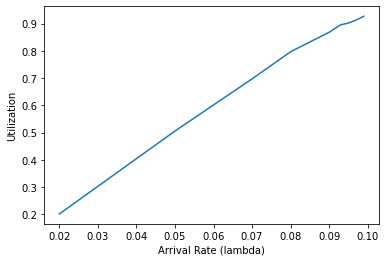

In [60]:
plt.xlabel("Arrival Rate (lambda)")
plt.ylabel("Utilization")
plt.plot(lmbdas, utilizations_rr)
plt.savefig('2_c.jpg' , bbox_inches='tight')
plt.show()

### ه

<div dir="rtl">

همانند قسمت قبل
با زیاد شدن
$\lambda$
این مقدار هم زیاد می‌شود چون تسک‌های بیشتری به 
cpu
داده می‌شود که در نتیجه
زمان
response
آن افزایش می‌یابد.

</div>


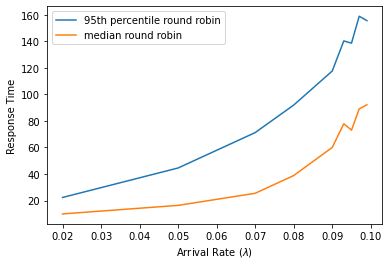

In [61]:
plt.xlabel("Arrival Rate ($\lambda$)")
plt.ylabel("Response Time")
plt.plot(lmbdas, response_time_95th_percentiles_rr, label="95th percentile round robin")
plt.plot(lmbdas, response_time_medians_rr, label="median round robin")
plt.legend()
plt.savefig('2_d.jpg' , bbox_inches='tight')
plt.show()

### و

<div dir="rtl">

بله اگر از 
srtf
استفاده کنیم معیار
median response time
مقدار زیادی بهتر خواهد شد چون 
task
هایی که زودتر تمام می‌شوند را سریع‌تر انجام می‌دهد اما براساس
95th percentile 
بدتر خواهد شد چون تسک‌های طولانی داریم و 
srtf
اولویت را به تسک‌های کوتاه می‌دهد و آن‌ها را با تاخیر زیادی اجرا می‌کند.

این موضوع داخل نمودار زیر هم مشخص است.

</div>

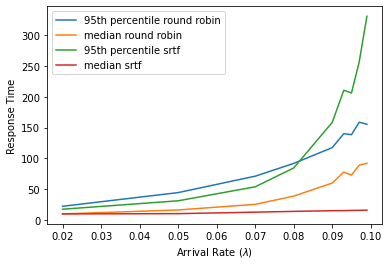

In [62]:
plt.xlabel("Arrival Rate ($\lambda$)")
plt.ylabel("Response Time")
plt.plot(lmbdas, response_time_95th_percentiles_rr, label="95th percentile round robin")
plt.plot(lmbdas, response_time_medians_rr, label="median round robin")
plt.plot(lmbdas, response_time_95th_percentiles_srtf, label="95th percentile srtf")
plt.plot(lmbdas, response_time_medians_srtf, label="median srtf")
plt.legend()
plt.savefig('2_e.jpg' , bbox_inches='tight')
plt.show()

### ز

<div dir="rtl">


زیاد شدن بهره‌وری(نزدیک 100%) به این معنا است که
cpu
همیشه یک تسک برای انجام دادن دارد و در نتیجه باعث می‌شود 
response time
به صورت کلی بالا برود چون این تسک‌ها امکان تداخل زمانی هم با هم دارند.

</div>

# Problem 3: Fairness for CPU Bursts

### آ
<div dir="rtl">


در کل دو تسک وجود دارد و از هر تسک هم حداکثر یکبار می‌تواند داخل صف باشد در نتیجه طول صف
همواره حداکثر $2$ خواهد بود.

</div>

### ب
<div dir="rtl">

با توجه به
i.i.d
بودن متغیر‌ها
می‌دانیم
احتمال کمتر بودن
$S$
از
$T$
و بلعکس برابر است.
</div>

$$P[S_1 < T_1] = P[S_1 > T_1]$$

$$P[S_1 < T_1] + P[S_1 > T_1] = 1$$

$$\xRightarrow[]{} P[S_1 < T_1] = \frac{1}{2}$$

### ج

<div dir="rtl">

طبق قانون حد مرکزی توزیع جمع تعداد زیادی($M$) متغیر تصادفی
i.i.d
به طور حدودی از توزیع زیر پیروی می‌کند.

</div>

$$N(m \times E[S_i] , m \times Var[S_i])$$

<div dir="rtl">
در نتیجه 
PDF
این متغیر تصادفی به صورت زیر است.
</div>

$$f_S(x) = \frac{1}{\sqrt{2m Var[S_i] \pi}} e ^ {-\frac{1}{2} (\frac{x - m E[S_i]}{\sqrt{m Var[S_i]}})^2}$$

### د

$$
\sigma = Var(S_i) , \mu = E[S_i]
\newline
\alpha S \sim N(\alpha m \mu , \alpha^2 m \sigma)
, T \sim N(m \mu , m \sigma)
\xRightarrow[]{} \alpha S - T \sim N((\alpha - 1) m \mu , (\alpha^2 + 1) m \sigma)
\newline
\xRightarrow[]{} \alpha S - T \sim (N(0,1) \times \sqrt{(\alpha^2 + 1) m \sigma}) + (\alpha - 1) m \mu
\newline
\xRightarrow[]{} P[\alpha S - T < 0] = P[N(0,1) \times \sqrt{(\alpha^2 + 1) m \sigma} + (\alpha - 1) m \mu < 0]
= P[N(0,1) < \frac{-(\alpha - 1) m \mu}{\sqrt{(\alpha^2 + 1) m \sigma}}]
\newline
= \boxed{\Phi(\frac{-(\alpha - 1) m \mu}{\sqrt{(\alpha^2 + 1) m \sigma}})}
$$


<div dir="rtl">

حال اگر فرض کنیم 
$\sqrt{\sigma} = \mu$
معادل عبارت زیر می‌شود.

</div>

$$\boxed{\Phi(\frac{-(\alpha - 1) m }{\sqrt{(\alpha^2 +1)m}})}$$

<div dir="rtl">



$$

### ه

<div dir="rtl">

$1.1 = \alpha$
قرار می‌دهیم و ابتدا به ازای
$100 = m$
و سپس به ازای
$10000 = m$
محاسبات را انجام می‌دهیم.

</div>

$$2 \Phi(\frac{-(1.1 - 1) \times 100}{\sqrt{(1.1 ^ 2 + 1) 100}}) = \boxed{0.501}$$

$$2 \Phi(\frac{-(1.1 - 1) \times 10000}{\sqrt{(1.1 ^ 2 + 1) 10000}}) = \boxed{1.74 \times 10^{-11}}$$

<div dir="rtl"> 

این محاسبات نشان می‌دهد ممکن است در مقدارهای کم
$m$
الگوریتم کمی نامنصفانه باشد اما در 
$m$
های بزرگتر به احتمال بسیار زیادی الگوریتم منصفانه خواهد بود. 
درباره‌ی
استدلال بهنام هم می‌توان گفت برای 
$m$
های نسبتا بزرگ درست است و این الگوریتم
منصفانه است اما برای 
$m$
های کوچک او اشتباه می‌کند.

</div>

In [101]:
import bisect

def create_problem3_task(lmbda, num_bursts):
    length = make_exponential(1 / lmbda)
    d = []
    sm = 0
    for i in range(num_bursts):
        d.append(length(0))
        sm += d[i]
    def next(x):
        next.id += 1
        return d[next.id]
    next.id = -1
    t = Task(0 , sm, next , nowait)
    return t

def create_problem3_workload(lmbda, num_bursts):
    task_S = create_problem3_task(lmbda, num_bursts)
    task_T = create_problem3_task(lmbda, num_bursts)
    return task_S, task_T

In [105]:
# Feel free to change this while developing if it takes too long to run
TRIALS = 5000
N = 1.1

unfair_count = 0
fair_count = 0

for _ in range(TRIALS):
    fcfs_cpu = fcfs(create_problem3_workload(.05, 100), False)
    elapsed_0 = fcfs_cpu.threads[0].elapsed_time
    elapsed_1 = fcfs_cpu.threads[1].elapsed_time
    if elapsed_0 / elapsed_1 > N or elapsed_1 / elapsed_0 > N:
        unfair_count += 1
    else:
        fair_count += 1
        
print("Fraction of runs that were unfair:", unfair_count / (fair_count + unfair_count))

Fraction of runs that were unfair: 0.5078


### ز

<div dir="rtl">

با توجه به خروجی بالا می‌توان نتایج به دست آمده را تایید کرد. همچنین قابل ذکر است که هر چقدر مقدار
$TRIALS$
را زیاد کنیم آزمایش به مقدار واقعی نزدیکتر می‌شود.

</div>


# Other Interesting Simulations

Here are some other interesting types of graphs you can make, that might be useful to you as you complete the assignment.

In [ ]:
# Useful functions to process the logs

def showQlen(cpulog):
    times = [x[0] for x in cpulog if x[1] == 'run']
    lengths = [x[4] for x in cpulog if x[1] == 'run']
    plt.plot(np.repeat(times,2)[1:], np.repeat(lengths,2)[0:-1])
    
def showQweight(cpulog):
    times = [x[0] for x in cpulog if x[1] == 'run']
    weights = [x[5] for x in cpulog if x[1] == 'run']
    plt.plot(np.repeat(times,2)[1:], np.repeat(weights,2)[0:-1])

In [ ]:
# Create tasks with exponentially distributed arrival times and run lengths
# The utilization is essentially the ratio of the means, but be careful as it gets loaded.
utilization = 0.9
interval = 40
run_length = interval*utilization
etasks = make_exp_arrivals(1 / interval, run_length, 200)

In [ ]:
ecpu_fcfs = fcfs(etasks)
wait_fcfs = sum([x.wait_time for x in ecpu_fcfs.threads])
ecpu_rr = round_robin(etasks, 5)
wait_rr = sum([x.wait_time for x in ecpu_rr.threads])

In [ ]:
wait_fcfs, wait_rr

In [ ]:
showQlen(ecpu_fcfs.log)

In [ ]:
showQlen(ecpu_rr.log)

In [ ]:
showQweight(ecpu_fcfs.log)

In [ ]:
showQweight(ecpu_rr.log)